# **SEISMOGRAMME (WELLENFORMEN)**

Willkommen zu unserem Python-Jupyter-Notebook "Seismogramme (Wellenformen)". Dieses Notebook wurde im Rahmen des seismo-at-school Projektes vom Schweizerischen Erdbebendienst (SED) an der ETH Zürich und Partnerinstitutionen entwickelt.

**Bitte klicke jeweils auf den Pfeil am linken Rand, um den Code auszuführen.**

Viel Vergnügen!

In [ ]:
# @title
import warnings
warnings.filterwarnings("ignore")
try:
    import obspy
except:
    !pip install obspy

try:
    import cartopy
except:
    !pip install cartopy

Gehe nun auf die Menuleiste oben, drücke "**Runtime**" und dann "**Restart session**". Drücke dann auf den nächsten Pfeil, um die Python Bibliotheken, die Du für die nachfolgenden Berechnungen benötigst, zu laden.

In [ ]:
# @title
import numpy as np
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace, Stats
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
model = TauPyModel(model="iasp91") # theoretische Ankunftszeiten von Wellenphasen

inv_ch = Client("ETH").get_stations(network="CH", station="*",
                                        location="--", channel="HH*", level='RESP')
inv_s = Client("ETH").get_stations(network="S", station="*",
                                        location="--", channel="EH*", level='RESP')

print("Ich habe " + str(len(inv_ch[0])) + " CH Breitband-Stationen und " + str(len(inv_s[0])) + " S Stationen gefunden.")

Ich habe 82 CH Stationen und 14 S Stationen gefunden.


# **1. Erdbeben weltweit**

Seismometer messen Erdbeben auf der ganzen Welt. Die Seismogramme (auch Wellenformen genannt) werden von Seismologen ausgewertet. Versuche es doch auch einmal!


## **Aufgaben:**
Wähle im Feld unten ein beliebiges Jahr (z.B. *year*= 2023) und eine minimale Magnitude (z.B. *minmag*= 7.0) aus.

In [ ]:
# Diese Parameter kannst Du ändern:
year   = 2024
minmag = 6.0

In [ ]:
# @title
# Diesen Code solltest Du nicht verändern:

maxmag = minmag + 1

try:
  if minmag>=6.0 and year>=1950:
    cat = Client("IRIS").get_events(minmag=minmag, starttime=obspy.UTCDateTime(str(year) + "-01-01T00:00"), endtime=obspy.UTCDateTime(str(year+1) + "-01-01T00:00"))

    print("Ich habe " + str(len(cat)) +" Erdbeben mit einer Magnitude zwischen " +str(minmag)+ " bis " +str(maxmag)+ " gefunden.")
    print(cat.__str__(print_all=True))
  else:
    print("Bitte wähle eine grössere Magnitude, damit das Erdbeben in den Seismogrammen gut sichtbar ist.")
except:
  print("Ich habe keine Erdbeben gefunden. Aendere Deine Parameter und versuche es noch einmal.")

Ich habe 2 Erdbeben mit einer Magnitude zwischen 6.0 bis 7.0 gefunden.
2 Event(s) in Catalog:
2024-01-01T07:18:42.037000Z | +37.196, +136.870 | 6.2  mb
2024-01-01T07:10:09.692000Z | +37.498, +137.242 | 7.5  mww


Kopiere die Herdzeit aus dem Erdbebenkatalog (linke Spalte) von einem einem beliebigen Erdbeben in das Feld unten (z.B. *origin_time*=obspy.UTCDateTime("2023-12-07T12:56:30.660000Z")):

In [ ]:
# Diesen Parameter kannst Du ändern:
origin_time=obspy.UTCDateTime("2024-01-01T07:10:09.692000Z")

In [ ]:
# @title
no = []
for idx, c in enumerate(cat):
  if (c.origins[0].time == origin_time):
    no = idx
try:
  eq_lat = cat[no].origins[0].latitude
  eq_lon = cat[no].origins[0].longitude
  eq_depth = cat[no].origins[0].depth/1000
  eq_mag = cat[no].magnitudes[0].mag

  print("Das Erdbeben ereigenete sich an Länge = " +str(eq_lat) +
        " Grad und Breite = " + str(eq_lon) + " Grad. Es hatte eine Tiefe von " + str(eq_depth) + " km und eine Magnitude von " +str(eq_mag) +".")
except:
  print("Ich habe kein Beben finden können. Probiere es nocheinmal mit einer anderen Herdzeit.")

Das Erdbeben ereigenete sich an Länge = 37.4976 Grad und Breite = 137.2416 Grad. Es hatte eine Tiefe von 10.0 km und eine Magnitude von 7.5.


Ihr habt ein RaspberryShake Seismometer an Eurer Schule? Wie heisst er (z.B. *rs_stations_my* = "KSSO")?

In [37]:
# Diesen Parameter kannst Du ändern:
#rs_stations_my = "RFE6B"
rs_stations_my = "KSSO"

Station S.KSSO ist 9376.8 km von dem Erdbeben entfernt.
Aufgrund dieser Entfernung handelt es sich um ein teleseismices Erdbeben.
Die ersten Erdbebenwellen erreichen Deine Station nach 752.5 Sekunden (roter Strich). Kannst Du sie erkennen?
Falls nicht, sind die Erschütterungen an Deiner Station vermutlich zu gering. Versuche es noch einmal mit einem stärkeren oder näheren Erdbeben.


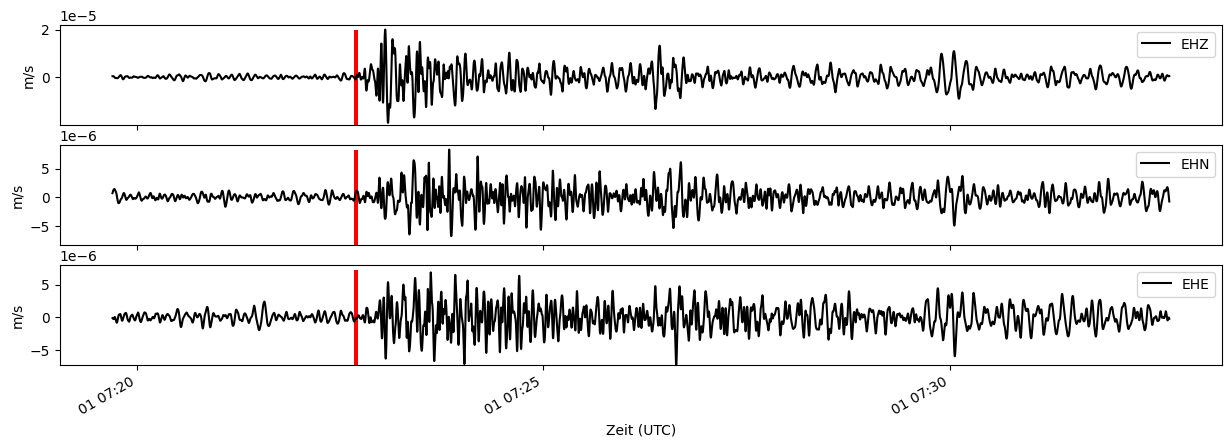

In [50]:
try:
  inv_rs = Client("ETH").get_stations(network="S", station=rs_stations_my,
                                        location="--", channel="EH*", level='RESP')
  sta_lat = inv_rs[0][0].latitude
  sta_lon = inv_rs[0][0].longitude
  epi_dist = (gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)[0]/1000)
  phase_arrivals = model.get_travel_times(source_depth_in_km=eq_depth,
                                          distance_in_degree=epi_dist/111.111,phase_list=["ttbasic"])


  if epi_dist >= 9000:
    eq_type = "teleseismic"
    freqmin = 0.1
    freqmax = 0.8
    timewindow_start = origin_time + phase_arrivals[0].time - 3 * 60
    timewindow_end = origin_time + phase_arrivals[0].time + 10 * 60
  elif epi_dist >= 600:
    eq_type = "regional"
    freqmin = 0.7
    freqmax = 2.0
    timewindow_start = origin_time + phase_arrivals[0].time - 0.5 * 60
    timewindow_end = origin_time + phase_arrivals[0].time + 5 * 60
  elif epi_dist >= 100:
    eq_type = "local"
    freqmin = 3.0
    freqmax = 8.0
    timewindow_start = origin_time
    timewindow_end = origin_time + 1 * 60
  else:
    eq_type = "hyperlocal"
    freqmin = 3.0
    freqmax = 20.0
    timewindow_start = origin_time
    timewindow_end = origin_time + 1 * 60

  print("Station S." + rs_stations_my + " ist " + str(round(epi_dist*10)/10) + " km von dem Erdbeben entfernt.")
  print("Aufgrund dieser Entfernung handelt es sich um ein " +str(eq_type) + "es Erdbeben.")

  stream = Client("ETH").get_waveforms(network="S", station=rs_stations_my, location="--", channel="EH*", starttime=timewindow_start - 60, endtime=timewindow_end + 60, attach_response=True)
  #stream.attach_response(inv_s)
  stream.merge(method=0, fill_value='interpolate')
  stream.remove_response(output='VEL')
  stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
  stream.trim(starttime = timewindow_start, endtime = timewindow_end)

  fig = plt.figure()
  for idx, trace in enumerate(stream):
    if trace.stats.channel == "EHZ":
      ax = fig.add_subplot(len(stream),1,1)
    elif trace.stats.channel == "EHN":
      ax = fig.add_subplot(len(stream),1,2)
    else:
      ax = fig.add_subplot(len(stream),1,3)
    ax.xaxis_date()
    trace.data = trace.data # meters/second
    ax.plot(trace.times("matplotlib"), trace.data, "k-", label = trace.stats.channel)
    plt.bar(origin_time + phase_arrivals[0].time, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()), width = 3.0, align = "center", color = "r")
    #for phase in phase_arrivals:
    #  print(phase)
    #  plt.bar(origin_time + phase.time, height =  1 * np.abs(trace.max()), bottom = -0.5 * np.abs(trace.max()), width = 0.5, align = "center", color = "b")
    plt.xlabel('Zeit (UTC)')
    plt.ylabel('m/s')
    plt.legend()
    fig.autofmt_xdate()

  fig.set_figheight(5)
  fig.set_figwidth(15)

  print("Die ersten Erdbebenwellen erreichen Deine Station nach " + str(round(phase_arrivals[0].time*10)/10) + " Sekunden (roter Strich). Kannst Du sie erkennen?")
  print("Falls nicht, sind die Erschütterungen an Deiner Station vermutlich zu gering. Versuche es noch einmal mit einem stärkeren oder näheren Erdbeben.")
  #print("Die Daten sind von " +str(freqmin) + " Hertz (Hz) bis " +str(freqmax) + " Hertz (Hz) gefiltert.")

except:
  print("Ich habe keine Daten für Deine Station gefunden. Versuche es nocheinmal.")

Klicke den Pfeil links, um die Seismogramme für Dein Erdbeben zu laden.

Network code S
Ich habe keine Seismogramme für EBUEL gefunden.
Ich habe keine Seismogramme für ELAUS gefunden.
Ich habe keine Seismogramme für EWATT gefunden.
Ich habe keine Seismogramme für ELFMC gefunden.
Ich habe keine Seismogramme für ESION gefunden.
Ich habe keine Seismogramme für EBELL gefunden.


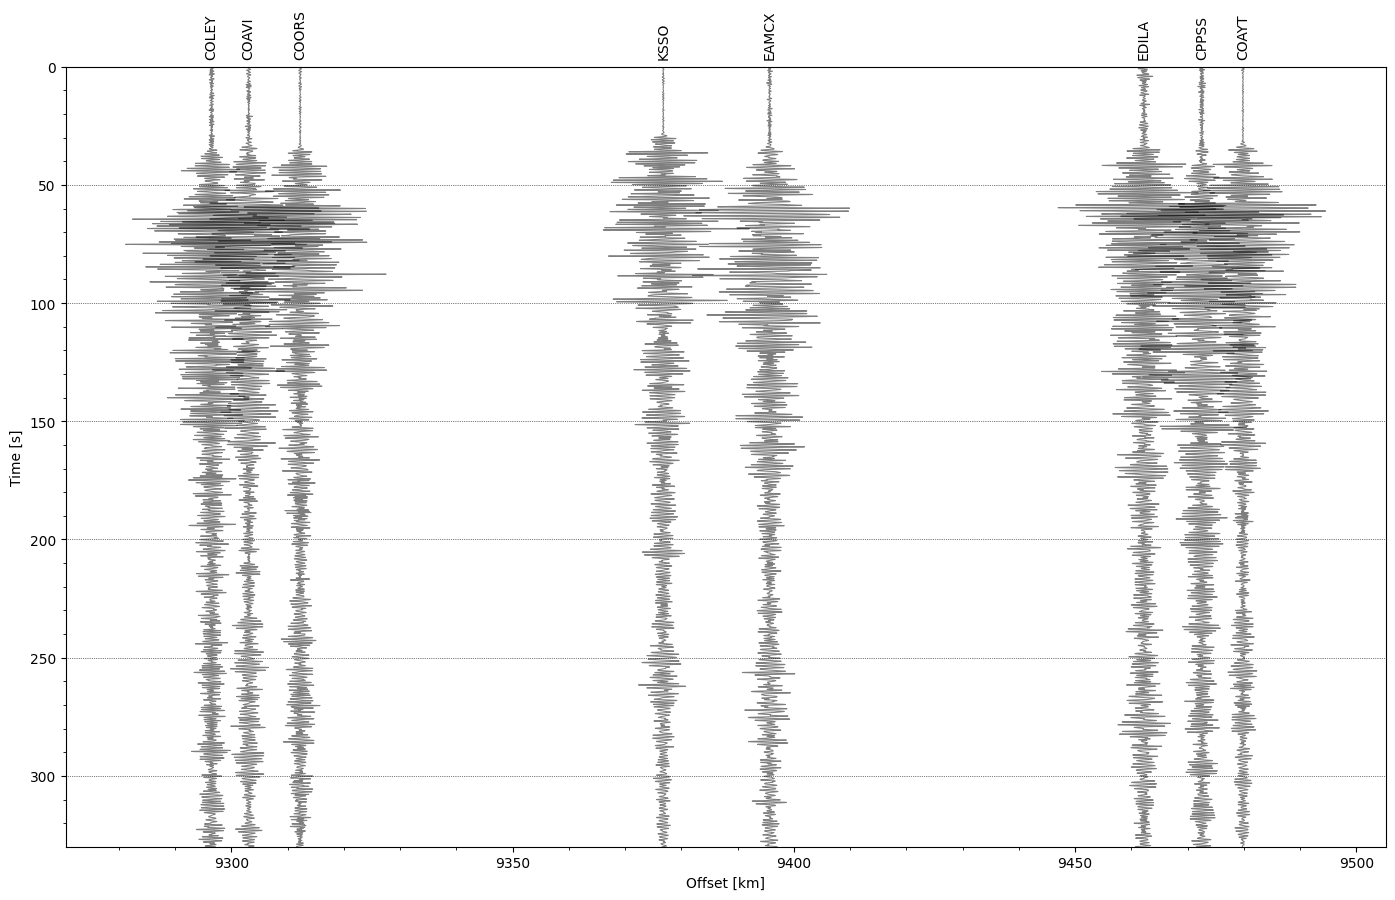

In [49]:
try:
  for network in ["S"]:
    print("Network code " + network)
    if network == "CH":
      inventory = inv_ch
    else:
      inventory = inv_s
    stream = Stream()

    for idx, inv in enumerate(inventory[0]):
      try:
        station = inv.code
        trace = Client("ETH").get_waveforms(network=network, station=station, location="--", channel="*Z", starttime=timewindow_start - 60, endtime=timewindow_end + 60, attach_response=True)
        trace.stats = Stats()
        stream += trace
      except:
        print("Ich habe keine Seismogramme für " +str(station) + " gefunden.")

    stream.merge(fill_value='interpolate')
    stream.remove_response(output='VEL')
    stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    stream.trim(starttime = timewindow_start, endtime = timewindow_end)

    for idx, trace in enumerate(stream):
      sta_lat = inventory[0][idx].latitude
      sta_lon = inventory[0][idx].longitude
      trace.stats.distance = gps2dist_azimuth(sta_lat, sta_lon, eq_lat, eq_lon)[0]

    fig = plt.figure()
    stream.plot(type='section', time_down=True, linewidth=.75, grid_linewidth=.5, show=False, fig=fig)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    # Plot customization: Add station labels to offset axis
    ax = fig.axes[0]
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    for trace in stream:
      ax.text(trace.stats.distance / 1e3, 1.01, trace.stats.station, rotation=90,
            va="bottom", ha="center", transform=transform, zorder=10)
    plt.show()
except:
  print("Fehler")